In [1]:
# CS180 (CS280A): Project 1
import numpy as np
import skimage as ski
import skimage.io as skio
import os
import cv2 as cv
import scipy 
import matplotlib.pyplot as plt
import tifffile

In [2]:
def normalize(im):
    return (im - np.mean(im))/np.std(im)

def ncc(im1, im2):
    return - 1.0/(im1.size-1) * np.sum(normalize(im1) * normalize(im2))

def l2dist(im1, im2):
    return np.linalg.norm(im1 - im2)

def l1dist(im1, im2):
    return np.linalg.norm(im1 - im2, ord=1)

def normL2dist(im1, im2):
    return np.linalg.norm(normalize(im1) - normalize(im2))

def align_naive(im1, im2, offset, metric, return_offset=False, k=10):
    best_score = float('inf')
    x, y = 0, 0
    if k < 1:
        k = int(k*min(im1.shape))
    im1_crop = im1[k:-k, k:-k]
    im2_crop = im2[k:-k, k:-k]
    half_offset = offset
    
    for i in range(-half_offset, half_offset + 1):
        for j in range(-half_offset, half_offset + 1):
            test = np.roll(im2_crop, (j, i), axis=(0, 1))
            score = metric(im1_crop, test)
            if (score < best_score):
                x, y = i, j
                best_score = score
    
    print(f"Best score: {best_score}, X: {x}, Y: {y}")
    
    if return_offset:
        return x, y
    return np.roll(im2, (y, x), axis=(0, 1))

def align_phase_corr(im1, im2, return_offset=False):
    fft_im1 = np.fft.fft2(im1)
    fft_im2 = np.fft.fft2(im2)
    prod = fft_im1 * np.conj(fft_im2)
    phase_corrs = np.fft.ifft2(np.divide(prod, np.absolute(prod)))
    y, x = np.unravel_index(np.argmax(phase_corrs), phase_corrs.shape)
    print("X", x, "Y", y)
    if return_offset:
        return x, y
    return np.roll(im2, (y, x), axis = (0,1))

def align_multiscale(im1, im2, depth, metric):
    if depth == 0:
        return align_naive(im1, im2, 15, metric, k = 0.1, return_offset=True)
    else:
        im1_ds, im2_ds = ski.transform.rescale(im1, 1/2, anti_aliasing=True), ski.transform.rescale(im2, 1/2, anti_aliasing = True)
        dx, dy = align_multiscale(im1_ds, im2_ds, depth-1, metric)
        dx, dy = 2*dx, 2*dy
        im2 = np.roll(im2, (dy, dx), axis = (0, 1))
        x, y = align_naive(im1, im2, 2, metric, return_offset=True, k=0.1)
        print("DEPTH", depth, "X", x+dx, "Y", y+dy)
        return x+dx, y+dy

In [6]:
jpgs = [i for i in os.listdir('data') if i.endswith(".tif")]
tifs = [i for i in os.listdir('data') if i.endswith(".tif")]
jpgs

['church.tif',
 'emir.tif',
 'harvesters.tif',
 'icon.tif',
 'lady.tif',
 'melons.tif',
 'onion_church.tif',
 'sculpture.tif',
 'self_portrait.tif',
 'sunset1_bgr.tif',
 'sunset1_bgryo.tif',
 'three_generations.tif',
 'train.tif',
 'yash_bgr.tif',
 'yash_obgry.tif']

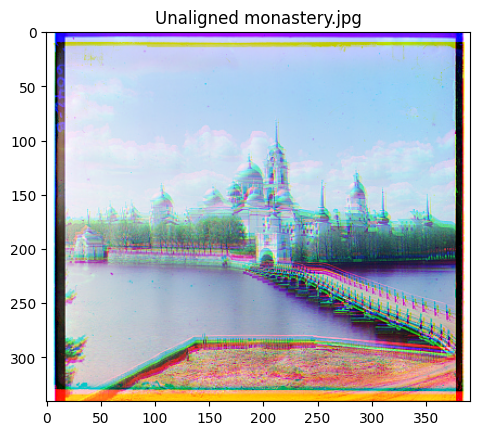

In [10]:
def process_img(filename):
    if filename.endswith(".tif"):
        im = tifffile.imread(f"data/{filename}")
    else:
        im = skio.imread(f"data/{filename}")
    im = ski.img_as_float(im)
    height = np.floor(im.shape[0] / 3.0).astype(int)
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    return [r, g, b]

def output_img(channels, title='', fn='', save_img=True):
    out = np.dstack(channels).astype(np.float64)
    plt.title(title)
    plt.imshow(out)
    if save_img:
        plt.imsave(fn, (out * 255).astype(np.uint8))
    return out

filename = 'monastery.jpg'
r, g, b = process_img(filename)
output_img([r, g, b], title=f"Unaligned {filename}", fn=f"outputs/unaligned_{filename}");

Best score: 75.2584138182711, X: 2, Y: 3
Best score: 51.77966019880518, X: 2, Y: -3


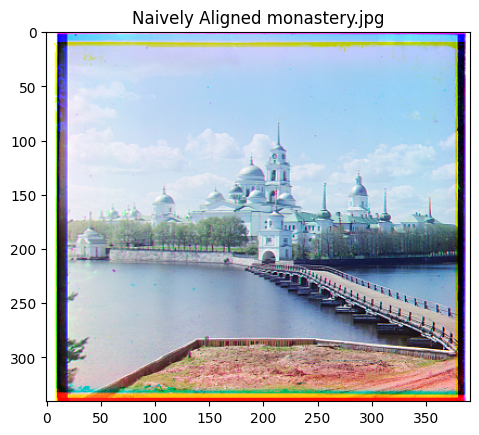

In [11]:
# Naive, diff_l2
metric = l2dist
aligned = [align_naive(b, r, 15, metric), align_naive(b, g, 15, metric), b]
output_img(aligned, title=f"Naively Aligned {filename}", fn=f"outputs/naive_{metric.__name__}_{filename}");

Best score: -0.6764055210213947, X: 2, Y: 3
Best score: -0.8275377507203361, X: 2, Y: -3


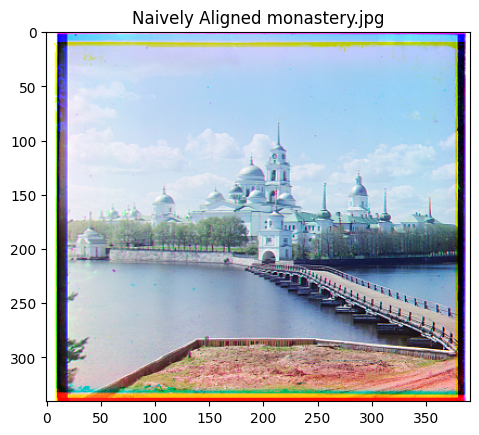

In [12]:
# Naive, norm_cross_corr
metric = ncc
aligned = [align_naive(b, r, 15, metric), align_naive(b, g, 15, metric), b]
output_img(aligned, title=f"Naively Aligned {filename}", fn=f"outputs/naive_{metric.__name__}_{filename}");

X 2 Y 3
X 2 Y 338


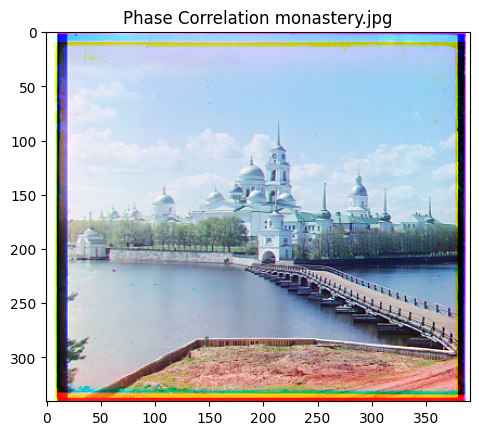

In [13]:
# phase correlation, norm_cross_corr
metric = ncc
aligned = [align_phase_corr(b, r), align_phase_corr(b, g), b]
output_img(aligned, title=f"Phase Correlation {filename}", fn=f"outputs/phasecorr_{metric.__name__}_{filename}");

# TIFs

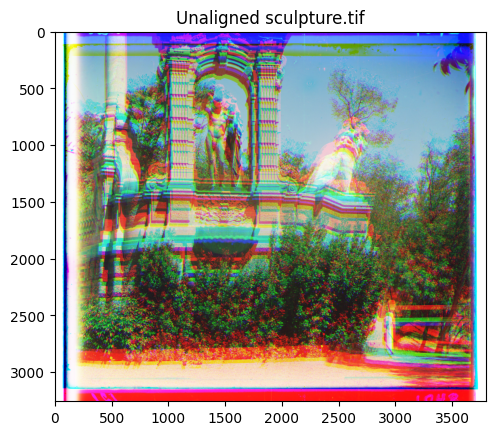

In [14]:
filename = 'sculpture.tif'
r, g, b = process_img(filename)
out_fn = f"{filename[:-4]}.jpg" if filename.endswith(".tif") else filename
output_img([r, g, b], title=f"Unaligned {filename}", fn=f"outputs/unaligned_{out_fn}");

In [15]:
# Naive, l2dist
metric = l2dist
aligned = [align_naive(b, r, 15, metric), align_naive(b, g, 15, metric), b]
output_img(aligned, title=f"Naively Aligned {filename}", fn=f"outputs/naive_{metric.__name__}_{out_fn}");

KeyboardInterrupt: 

Best score: -0.43188456326372676, X: -1, Y: 15
Best score: -0.6356479849398462, X: 0, Y: 15


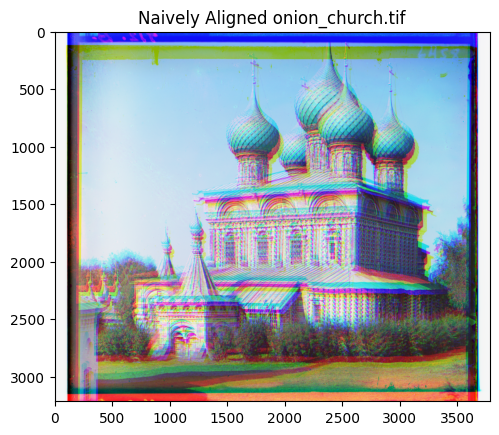

In [ ]:
# Naive, ncc
metric = ncc
aligned = [align_naive(b, r, 15, metric), align_naive(b, g, 15, metric), b]
output_img(aligned, title=f"Naively Aligned {filename}", fn=f"outputs/naive_{metric.__name__}_{out_fn}");

Best score: 15.975339215237856, X: -1, Y: 4
Best score: 32.05458721724763, X: 0, Y: 1
DEPTH 1 X -2 Y 9
Best score: 65.4331989065682, X: 1, Y: -1
DEPTH 2 X -3 Y 17
Best score: 132.5095978386193, X: -1, Y: 1
DEPTH 3 X -7 Y 35
Best score: 273.513779192323, X: 1, Y: 0
DEPTH 4 X -13 Y 70
Best score: 554.5409350967269, X: -1, Y: 0
DEPTH 5 X -27 Y 140
Best score: 11.331832284599368, X: 0, Y: 1
Best score: 23.19641688558632, X: -1, Y: 0
DEPTH 1 X -1 Y 2
Best score: 47.33486978297605, X: 1, Y: 0
DEPTH 2 X -1 Y 4
Best score: 98.968634151895, X: -1, Y: 0
DEPTH 3 X -3 Y 8
Best score: 207.17146281759116, X: 1, Y: 1
DEPTH 4 X -5 Y 17
Best score: 416.7466933719921, X: -1, Y: -1
DEPTH 5 X -11 Y 33


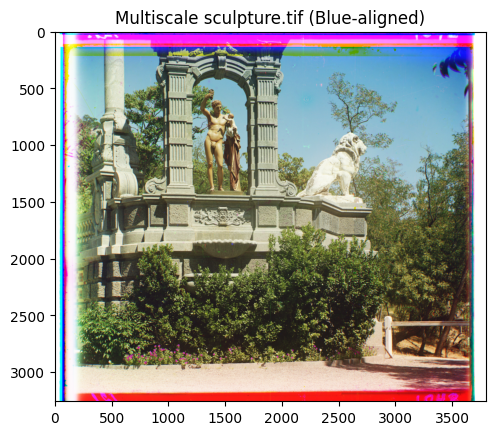

In [16]:
metric = l2dist
ar = np.roll(r, align_multiscale(b, r, 5, metric= metric), axis=(1, 0))
ag = np.roll(g, align_multiscale(b, g, 5, metric = metric), axis=(1, 0))
output_img([ar, ag, b], title=f"Multiscale {filename} (Blue-aligned)", fn=f"outputs/multiscale_{metric.__name__}_bluealigned_{out_fn}");

Best score: 11.42293894262925, X: 0, Y: -2
Best score: 23.128369198800243, X: -1, Y: 0
DEPTH 1 X -1 Y -4
Best score: 44.834068825698985, X: 1, Y: 1
DEPTH 2 X -1 Y -7
Best score: 93.81855103562754, X: -1, Y: 0
DEPTH 3 X -3 Y -14
Best score: 195.27280236153925, X: 1, Y: 0
DEPTH 4 X -5 Y -28
Best score: 392.91984548987347, X: 0, Y: -1
DEPTH 5 X -10 Y -57
Best score: 17.413498866928272, X: -1, Y: -3
Best score: 32.309240472786584, X: 0, Y: -1
DEPTH 1 X -2 Y -7
Best score: 66.15131232685758, X: 0, Y: 0
DEPTH 2 X -4 Y -14
Best score: 130.97832453936394, X: -1, Y: 1
DEPTH 3 X -9 Y -27
Best score: 268.3318301148395, X: 0, Y: 0
DEPTH 4 X -18 Y -54
Best score: 540.8226839172975, X: 0, Y: 0
DEPTH 5 X -36 Y -108


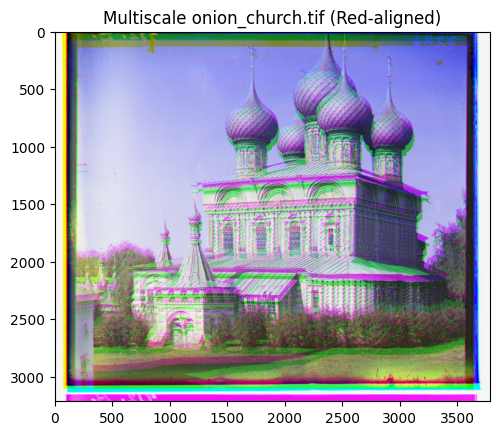

In [ ]:
# metric = l2dist
# ar = np.roll(r, align_multiscale(g, r, 5, metric= metric), axis=(1, 0))
# ab = np.roll(b, align_multiscale(g, b, 5, metric= metric), axis=(1, 0))
# output_img([ar, g, ab], title=f"Multiscale {filename} (Green-aligned)", fn=f"outputs/multiscale_{metric.__name__}_greenaligned_{out_fn}");

# metric = l2dist
# ag = np.roll(r, align_multiscale(r, g, 5, metric= metric), axis=(1, 0))
# ab = np.roll(b, align_multiscale(r, b, 5, metric = metric), axis=(1, 0))
# output_img([r, ag, ab], title=f"Multiscale {filename} (Red-aligned)", fn=f"outputs/multiscale_{metric.__name__}_redaligned_{out_fn}");

X 3773 Y 140
X 3789 Y 33


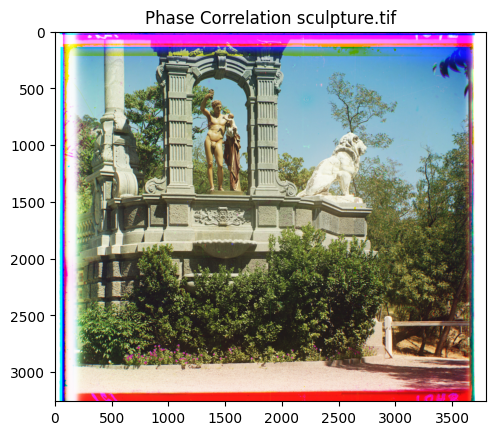

In [23]:
# phase correlation, norm_cross_corr
metric = ncc
aligned = [align_phase_corr(b, r), align_phase_corr(b, g), b]
out = output_img(aligned, title=f"Phase Correlation {filename}", fn=f"outputs/phasecorr_{out_fn}");

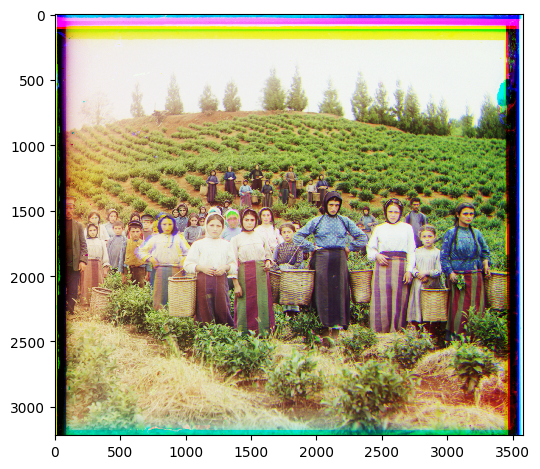

In [47]:
import numpy as np
import cv2
from scipy import ndimage

def auto_crop_noisy(image_array):
    # Convert 64-bit float to 8-bit uint
    if image_array.dtype == np.float64:
        image_array = (image_array * 255).clip(0, 255).astype(np.uint8)
    
    # Ensure 3 channels (RGB)
    if len(image_array.shape) == 2:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
    elif image_array.shape[2] == 4:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    
    # Detect edges
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate edges to close gaps
    dilated = cv2.dilate(edges, None)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image_array  # Return original if no contours found
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add padding (adjust as needed)
    padding = 10
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image_array.shape[1] - x, w + 2*padding)
    h = min(image_array.shape[0] - y, h + 2*padding)
    
    # Crop the image
    cropped = image_array[y:y+h, x:x+w]
    
    return cropped

# Usage
# Assuming 'image_array' is your NumPy array with shape (height, width, 3) or (height, width)
cropped_array = auto_crop_noisy(out)
skio.imshow(cropped_array)